# Решение для курса "Прикладное машинное обучение"

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Бизнес-постановка задачи  

Банк в рамках своей новой стратегии по удержанию клиентов решил предлагать персонализированные предложения для своих клиентов. Но предлагать уникальные условия каждому клиенту - слишком дорого, поэтому было принято решение предлагать эти условия только тем, кто в скором времени может уйти. Нужно определить, уйдёт ли клиент в этом (2020) году или нет

## Постановка ML-задачи  

На основе данных о пользователе за предыдущие 2 года построить модель, которая определит, уйдёт пользователь или нет.  
Бинарная классификация.

## Выбор метрики

В качестве метрики качества модели была выбрана ROC AUC как самая универсальная в задачах бинарной классификации.  
Эта метрика не зависит ни от модели, ни от соотношения положительных и отрицательных примеров в выборке (о соотношении - ниже). Также с помощью этой метрики легко сравнивать модели - чем больше ROC AUC, тем лучше.

## EDA

Взглянем на данные

In [61]:
data = pd.read_csv('data.csv')
data.head(10)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Trans_Ct,Quarter,Year,Date_Leave
0,708082083,Existing Customer,46,F,High School,Married,$40K - $60K,Blue,48,4,2,3,3544,943,44,none,2019,"none,2019"
1,708082083,Existing Customer,45,F,High School,Married,$40K - $60K,Blue,36,4,3,3,3544,1661,111,none,2018,"none,2018"
2,708083283,Attrited Customer,58,M,College,Single,$40K - $60K,Blue,45,3,1,3,3421,2517,21,Q4,2018,"Q4,2018"
3,708084558,Attrited Customer,60,M,Graduate,Divorced,$60K - $80K,Silver,38,6,3,3,8258,1771,23,Q2,2018,"Q2,2018"
4,708085458,Attrited Customer,35,F,Uneducated,Single,Less than $40K,Blue,36,6,2,2,1500,784,47,Q4,2019,"Q4,2019"
5,708085458,Existing Customer,34,F,Uneducated,Single,Less than $40K,Blue,24,6,2,2,"1438,3",0,82,none,2018,"none,2018"
6,708086958,Existing Customer,50,F,High School,Married,Less than $40K,Blue,53,3,1,2,3128,232,80,none,2019,"none,2019"
7,708086958,Existing Customer,49,F,High School,Married,Less than $40K,Blue,41,3,5,2,3128,749,59,none,2018,"none,2018"
8,708095133,Existing Customer,44,M,Graduate,Married,$120K +,Platinum,46,5,6,2,33304,1041,56,none,2019,"none,2019"
9,708095133,Existing Customer,43,M,Graduate,Married,$120K +,Platinum,34,5,2,2,33304,1833,29,none,2018,"none,2018"


In [62]:
print("Размер выобрки: " + str(data.shape[0]))

Размер выобрки: 20071


### Описание колонок  

**CLIENTNUM** - ID клиента;  
**Attrition_Flag** - Existing customer - активный клиент, Attrited customer - ушедший клиент;  
**Customer_Age** - Возраст;  
**Gender** - Пол;  
**Education_Level** - Уровень образования;  
**Marital_Status** - Семейное положение;  
**Income_Category** - Доход;  
**Card_Category** - Тип карты;  
**Months_on_book** - Количество месяцев пользования услугами банка;  
**Total_Relationship_Count** - Количество связей с банком;  
**Months_Inactive_12_mon** - Количество неактивных месяцев за последний год;  
**Contacts_Count_12_mon** - Количество контактов с банком за последний год;  
**Credit_Limit** - Кредитный лимит;  
**Total_Revolving_Bal** - Возобновляющийся баланс;  
**Total_Trans_Ct** - Количество транзакций;  
**Quarter** - Квартал - указан, если клиент ушёл;  
**Year** - Год;  
**Date_Leave** - Дата ухода клиента.

### Анализ колонок  

Attrition_Flag - целевая переменная. При этом Quarter и Date_Leave напрямую зависят от Attrition_Flag, поэтому должны быть исключены при обучении. 

In [63]:
existing_customer_count = data[data.Attrition_Flag == 'Existing Customer'].shape[0]
existing_customer_count_without_quarter = data[(data.Attrition_Flag == 'Existing Customer') & (data.Quarter == 'none')].shape[0]
existing_customer_count_without_data_leave = data[(data.Attrition_Flag == 'Existing Customer') & (data.Date_Leave.str.startswith('none'))].shape[0]

assert existing_customer_count == existing_customer_count_without_quarter
assert existing_customer_count == existing_customer_count_without_data_leave

Помимо этого стоит обратить внимание на то, что в данных смешаны наблюдения за два года - 2018 и 2019. При обучении данные нужно по особенному разбивать на test и train, а также при кроссс валидации, чтобы не допустить data leak "из будущего в прошлое".  

Ещё стоит убрать при обучении CLIENTNUM, так как полезной информации оно не несёт, а в связке с временнЫми данными может вести к переобучению.

### Чистка данных  

Можно заметить, что в колонке Credit_Limit присутствуют дробные значения, при этом pandas определил тип это колонки как "object"

In [64]:
data.Credit_Limit.dtype

dtype('O')

Преведём к флоат

In [65]:
data.Credit_Limit = data.Credit_Limit.map(lambda s: float(s.replace(",", "."))).astype(float)

## Визуальный анализ

### Распределение значений по колонкам

In [66]:
def bar_chart(column, ax):
    ax.set_title(column)
    counts = data[column].value_counts()
    ax.bar(counts.index, counts.values)
    
def hist_chart(column, ax):
    ax.set_title(column)
    ax.hist(data[column], bins=5)

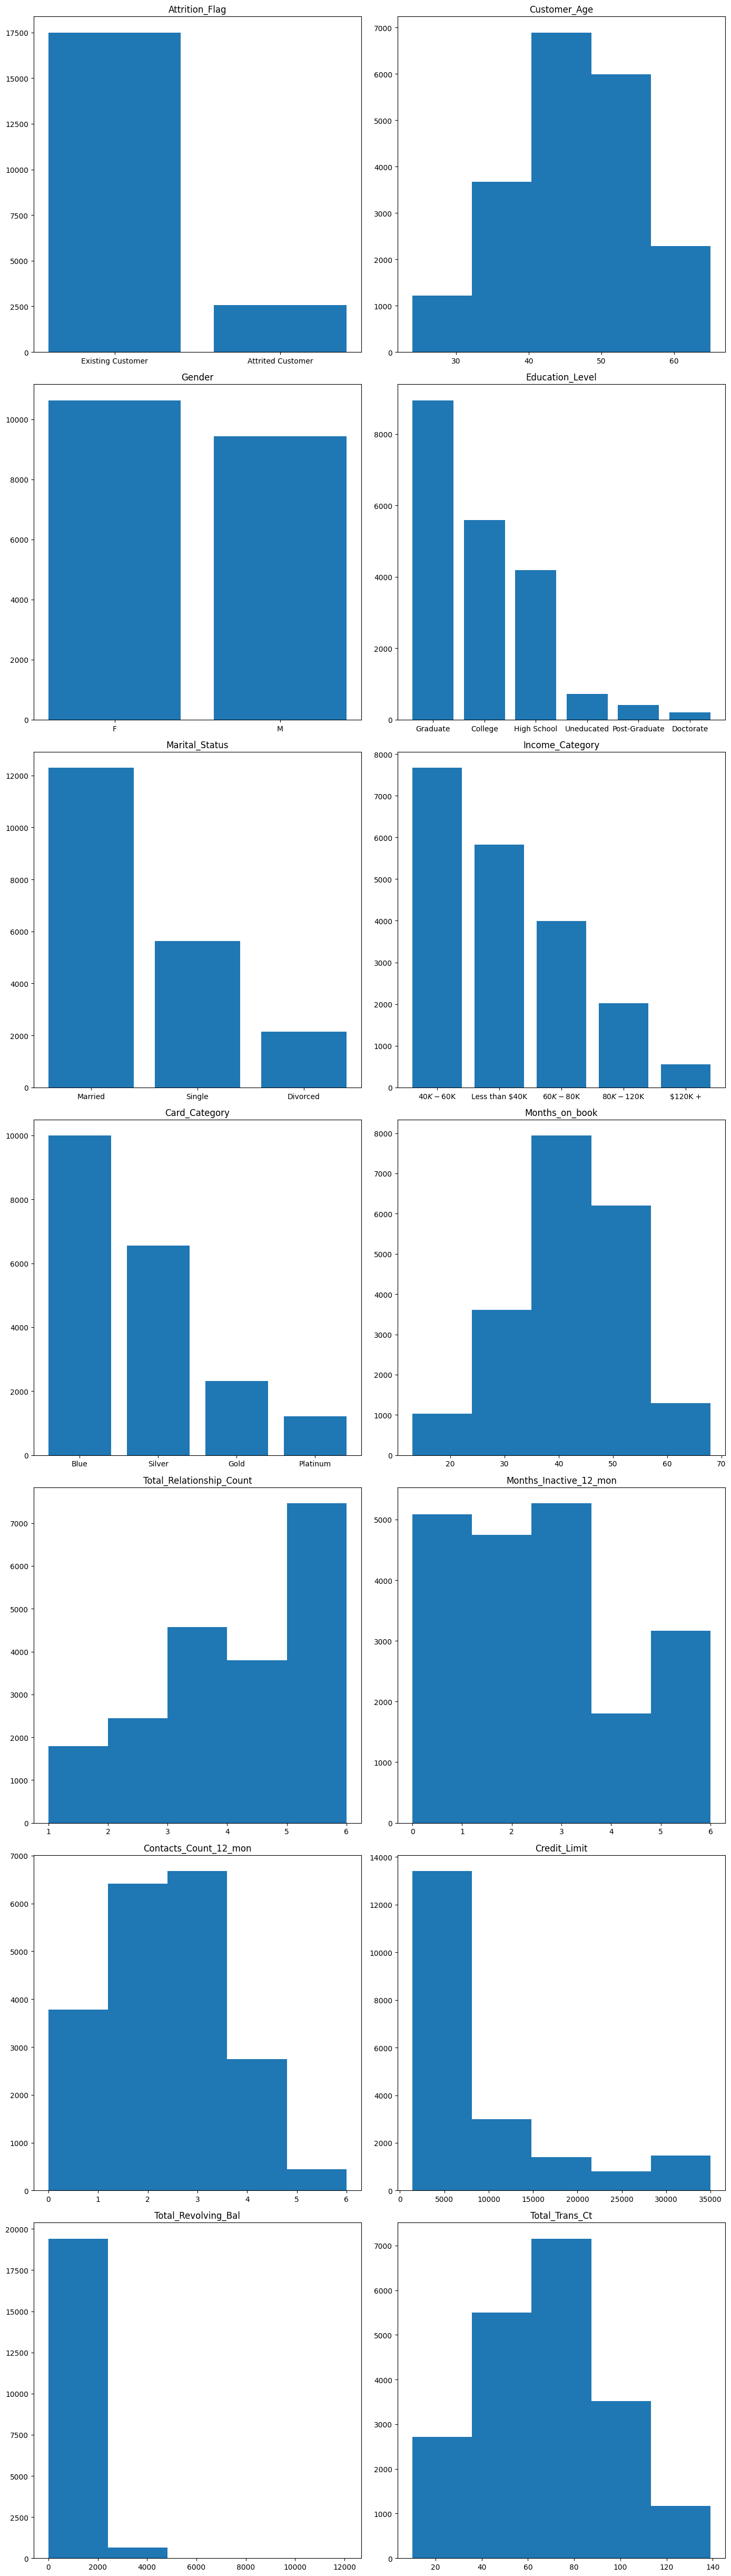

In [67]:
fig, axs = plt.subplots(7, 2, figsize=(14, 49))

bar_chart('Attrition_Flag', axs[0][0])
hist_chart('Customer_Age', axs[0][1])
bar_chart('Gender', axs[1][0])
bar_chart('Education_Level', axs[1][1])
bar_chart('Marital_Status', axs[2][0])
bar_chart('Income_Category', axs[2][1])
bar_chart('Card_Category', axs[3][0])
hist_chart('Months_on_book', axs[3][1])
hist_chart('Total_Relationship_Count', axs[4][0])
hist_chart('Months_Inactive_12_mon', axs[4][1])
hist_chart('Contacts_Count_12_mon', axs[5][0])
hist_chart('Credit_Limit', axs[5][1])
hist_chart('Total_Revolving_Bal', axs[6][0])
hist_chart('Total_Trans_Ct', axs[6][1])

plt.tight_layout()
plt.show()

В глаза сразу брасается соотношение классов: положительного класса (Attrited customer) в ~7 раз меньше, чем отрицательного (Existing customer)